In [63]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

In [64]:
df = pd.read_pickle("./shows_df_final.pkl")

In [65]:
df.head()

,link,imdb_rating,title,s01_episodes,avg_runtime,genres,rel_date,certification,origin,creators,creators_a,stars,stars_a
0,https://www.imdb.com/title/tt7670568,5.8,The Masked Singer,10,60,"[Game-Show, Music, Reality-TV]",2019-01-02,TV-PG,United States,[],[],"[Jenny McCarthy-Wahlberg, Ken Jeong, Nicole Sc...","[3, 5, 1]"
1,https://www.imdb.com/title/tt8001250,6.2,Siempre Bruja,11,40,"[Drama, Fantasy]",2019-01-01,TV-14,Colombia,[],[],"[Sofía Araujo Mejía, Angely Gaviria, Sofía Ara...","[0, 0, 0]"
2,https://www.imdb.com/title/tt8115560,6.6,Tidying Up with Marie Kondo,8,40,[Reality-TV],2019-01-01,TV-PG,United States,[Marie Kondo],[1],"[Marie Kondo, Charlotte Hervieux, Marie Iida]","[1, 0, 0]"
3,https://www.imdb.com/title/tt8324422,8.0,PEN15,10,30,[Comedy],2019-02-08,TV-MA,United States,"[Anna Konkle, Maya Erskine, Sam Zvibleman]","[1, 1, 4]","[Maya Erskine, Anna Konkle, Melora Walters]","[1, 1, 5]"
4,https://www.imdb.com/title/tt8888322,6.6,Bloom,6,60,"[Drama, Mystery, Sci-Fi]",2019-01-01,,Australia,[Glen Dolman],[5],"[Bryan Brown, Phoebe Tonkin, Genevieve Morris]","[11, 0, 1]"


# DATA CLEANING, PREPARATION AND INITIAL EXPLORATIONS

GENRES

In [66]:
genres_l = set(df.genres.sum())

In [67]:
def m(x):
    if i in x:
        return 1
    else:
        return 0
    
for i in genres_l:
    df[i] = df.genres.apply(m)

In [68]:
df[['imdb_rating'] + list(genres_l)].corr().iloc[:,0]

imdb_rating    1.000000
Crime          0.039858
Romance        0.043632
Comedy         0.022811
News           0.068882
Adventure     -0.003245
Sport          0.068076
Sci-Fi        -0.105947
Game-Show     -0.046658
Musical       -0.054358
Mystery       -0.001192
Reality-TV    -0.079145
Western        0.041386
History        0.055213
Short         -0.056626
Drama          0.028846
Action        -0.000138
Biography      0.068172
Animation      0.036408
Horror        -0.099628
Fantasy        0.002337
Music          0.014256
Family        -0.048625
War            0.014655
Talk-Show     -0.002762
Thriller       0.032615
Documentary    0.030794
Name: imdb_rating, dtype: float64

In [7]:
df.rename(columns={"Talk-Show": "Talk_Show", "Sci-Fi": "Sci_Fi", "Game-Show": "Game_Show", "Reality-TV":"Reality_TV"}, inplace=True)

RELEASE DATE

In [8]:
df['rel_month']= pd.DatetimeIndex(df['rel_date']).month #creating release month column

CERTIFICATION

In [9]:
#after exploration looks like over 457 of the shows have no certification info, still will keep that column to anlyse shows that have certification info
df['certification'][df.certification.apply(len)>7] = "0"
df['certification'][df.certification==''] = "0"

#unification of the certification
df['certification'][df.certification=='TV-Y7'] = "TV-PG"
df['certification'][df.certification=='TV-G'] = "TV-PG"
df['certification'][df.certification=='TV-Y'] = "TV-PG"
df['certification'][df.certification=='PG'] = "TV-PG"
df['certification'][df.certification=='PG-13'] = "TV-14"

df.certification.value_counts()

/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_36167/1279704069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certification'][df.certification.apply(len)>7] = "0"
/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_36167/1279704069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certification'][df.certification==''] = "0"
/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_36167/1279704069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

0        457
TV-MA    446
TV-14    312
TV-PG    136
Name: certification, dtype: int64

In [10]:
df['TV_PG'] = (df['certification'] == 'TV-PG').apply(int)
df['TV_14'] = (df['certification'] == 'TV-14').apply(int)
df['TV_MA'] = (df['certification'] == 'TV-MA').apply(int)

ORIGIN

In [11]:
df.origin.value_counts()
# I will simplyfy that column to boolean 'made_in_usa'

United States             516
India                     159
United Kingdom            132
Japan                      84
South Korea                82
Turkey                     63
Spain                      28
Sweden                     20
Canada                     19
Italy                      17
Australia                  17
China                      17
France                     17
Norway                     15
Thailand                   14
Iran                       14
Serbia                     12
Germany                    12
Mexico                     12
Denmark                    11
Brazil                     10
Pakistan                    7
Egypt                       5
Taiwan                      5
Ireland                     5
South Africa                4
Russia                      4
Israel                      4
Belgium                     3
New Zealand                 3
Bangladesh                  3
Colombia                    3
Poland                      3
Netherland

In [12]:
df['made_in_usa'] = (df.origin == 'United States').apply(int)

In [13]:
df[['imdb_rating', 'made_in_usa']].corr()

,imdb_rating,made_in_usa
imdb_rating,1.000000,-0.165782
made_in_usa,-0.165782,1.000000


AWARDS

In [14]:
df['creators_a_n']= df.creators_a.apply(sum) #counting awards for creators, stars and sum of them
df['stars_a_n']= df.stars_a.apply(sum)
df['awards_n'] = df['creators_a_n'] + df['stars_a_n']

df.head()

,link,imdb_rating,title,s01_episodes,avg_runtime,genres,rel_date,certification,origin,creators,...,Thriller,Documentary,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,creators_a_n,stars_a_n,awards_n
0,https://www.imdb.com/title/tt7670568,5.8,The Masked Singer,10,60,"[Game-Show, Music, Reality-TV]",2019-01-02,TV-PG,United States,[],...,0,0,1,1,0,0,1,0,9,9
1,https://www.imdb.com/title/tt8001250,6.2,Siempre Bruja,11,40,"[Drama, Fantasy]",2019-01-01,TV-14,Colombia,[],...,0,0,1,0,1,0,0,0,0,0
2,https://www.imdb.com/title/tt8115560,6.6,Tidying Up with Marie Kondo,8,40,[Reality-TV],2019-01-01,TV-PG,United States,[Marie Kondo],...,0,0,1,1,0,0,1,1,1,2
3,https://www.imdb.com/title/tt8324422,8.0,PEN15,10,30,[Comedy],2019-02-08,TV-MA,United States,"[Anna Konkle, Maya Erskine, Sam Zvibleman]",...,0,0,2,0,0,1,1,6,7,13
4,https://www.imdb.com/title/tt8888322,6.6,Bloom,6,60,"[Drama, Mystery, Sci-Fi]",2019-01-01,0,Australia,[Glen Dolman],...,0,0,1,0,0,0,0,5,12,17


In [15]:
df.corr().iloc[:1]

,imdb_rating,s01_episodes,avg_runtime,Crime,Romance,Comedy,News,Adventure,Sport,Sci_Fi,...,Thriller,Documentary,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,creators_a_n,stars_a_n,awards_n
imdb_rating,1.0,0.040933,0.073512,0.039858,0.043632,0.022811,0.068882,-0.003245,0.068076,-0.105947,...,0.032615,0.030794,0.029798,-0.111316,-0.025413,-0.034024,-0.165782,0.000685,0.058616,0.04947


In [16]:
(pd.Series((df.creators+df.stars).sum()).value_counts() > 3).sum() #it does not seem interesting to explore particular names as in explored time period only 12 artists manageged to work in more than 3 shows

12

In [17]:
df.columns

Index(['link', 'imdb_rating', 'title', 's01_episodes', 'avg_runtime', 'genres',
       'rel_date', 'certification', 'origin', 'creators', 'creators_a',
       'stars', 'stars_a', 'Crime', 'Romance', 'Comedy', 'News', 'Adventure',
       'Sport', 'Sci_Fi', 'Game_Show', 'Musical', 'Mystery', 'Reality_TV',
       'Western', 'History', 'Short', 'Drama', 'Action', 'Biography',
       'Animation', 'Horror', 'Fantasy', 'Music', 'Family', 'War', 'Talk_Show',
       'Thriller', 'Documentary', 'rel_month', 'TV_PG', 'TV_14', 'TV_MA',
       'made_in_usa', 'creators_a_n', 'stars_a_n', 'awards_n'],
      dtype='object')

# EDA, CHOOSING FEATURES FOR REGRESSION MODEL

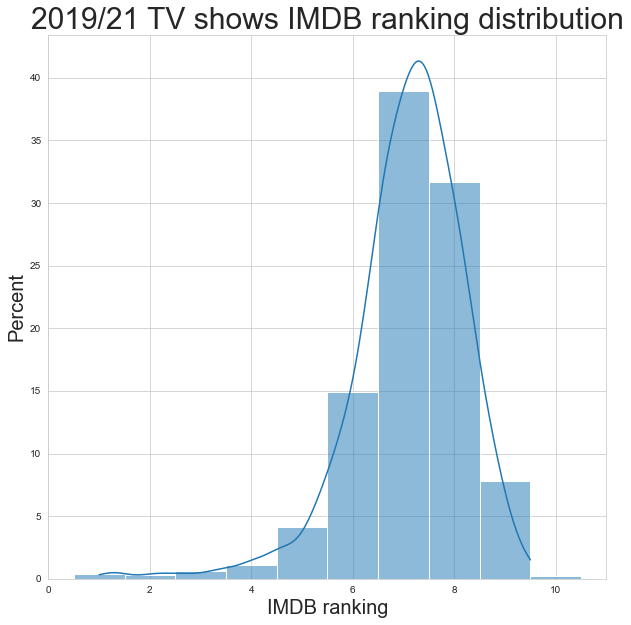

In [18]:
plt.figure(figsize = [10,10])
sns.set_style("whitegrid")
sns.histplot(df.imdb_rating, stat="percent", discrete=True, kde=True)
plt.title('2019/21 TV shows IMDB ranking distribution',  fontsize = 30)
plt.ylabel('Percent', fontsize = 20)
plt.xlabel('IMDB ranking', fontsize = 20)
plt.savefig('imdb_hist_plot', bbox_inches = 'tight');

In [21]:
x = df.corr().iloc[:,0]#checking correlations between taget and features
x = list(x[abs(x)>0.05].index)
x

['imdb_rating',
 'avg_runtime',
 'News',
 'Sport',
 'Sci_Fi',
 'Musical',
 'Reality_TV',
 'History',
 'Short',
 'Biography',
 'Horror',
 'TV_PG',
 'made_in_usa',
 'stars_a_n']

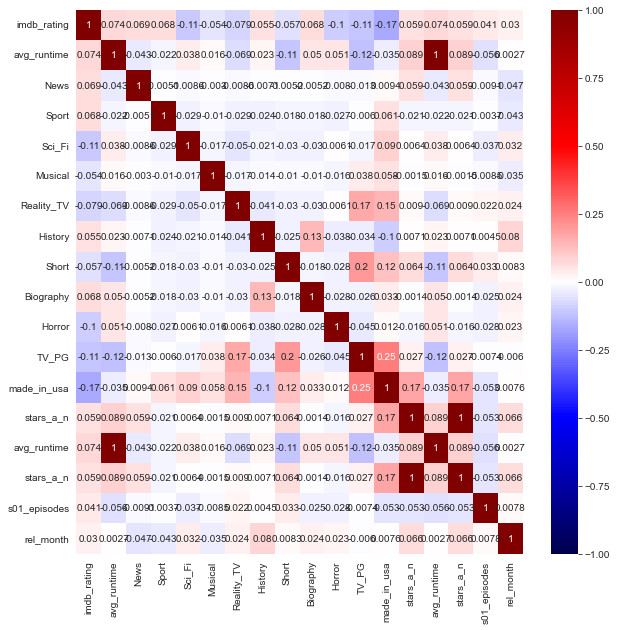

In [22]:
plt.figure(figsize = [10,10])
sns.heatmap(df[x + ['avg_runtime', 'stars_a_n', 's01_episodes', 'rel_month']].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.savefig('imdb_heat_map', bbox_inches = 'tight');

<Figure size 720x720 with 0 Axes>

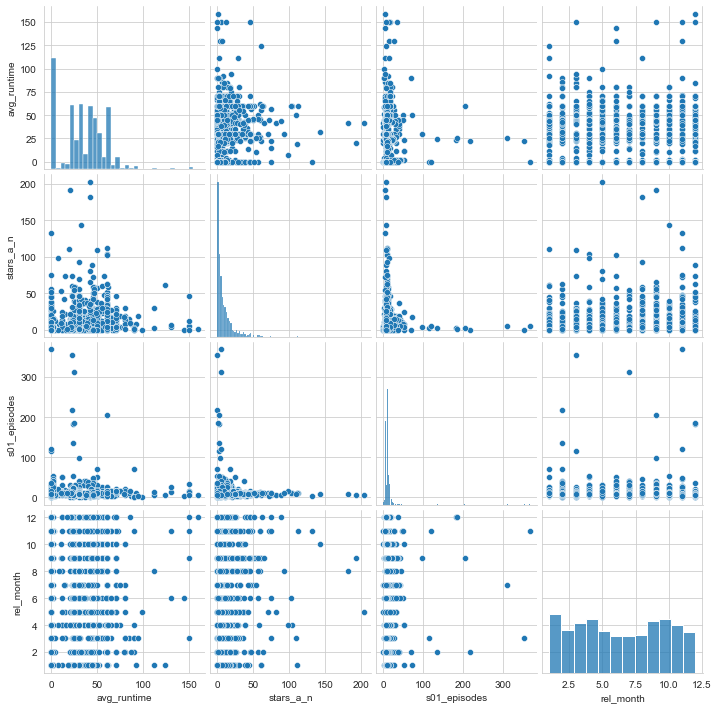

In [23]:
plt.figure(figsize = [10,10])
sns.pairplot(df[['avg_runtime', 'stars_a_n', 's01_episodes', 'rel_month']])
plt.savefig('imdb_pair_plot', bbox_inches = 'tight');

# REGRESSION MODEL

In [24]:
#y, X = patsy.dmatrices('imdb_rating ~  s01_episodes + avg_runtime + Horror + Romance + Short + Crime + Game_Show + Sport + Documentary + Biography + Musical + Western + Reality_TV + History + Family + Sci_Fi + Thriller+ Animation + News + TV_PG + TV_MA + made_in_usa + stars_a_n + awards_n', data=df, return_type="dataframe")
y = df.imdb_rating
X = df.drop(columns=['imdb_rating', 'link', 'title', 'genres', 'rel_date', 'certification', 'origin', 'creators', 'stars', 'creators_a', 'stars_a'], axis=1)
X = sm.add_constant(X).astype(float)

STANDARD SCALER

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in ['s01_episodes', 'avg_runtime','creators_a_n', 'stars_a_n', 'awards_n']:
    X[i] = pd.DataFrame(scaler.fit_transform(X[[i]]), columns=[i])


DATA SPIT FOR TESTING

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# As there is relatively not a lot of data points, I hold out 20% of the data for final testing, I could proceed with K fold but to keep it simple I stay with that solution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

INITIAL MODEL

In [116]:
model = sm.OLS(y_train, X_train)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     3.951
Date:                Fri, 08 Jul 2022   Prob (F-statistic):           3.67e-13
Time:                        20:16:38   Log-Likelihood:                -1610.9
No. Observations:                1080   AIC:                             3294.
Df Residuals:                    1044   BIC:                             3473.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.0019      0.138     50.713      0.000       6.731       7.273
s01_episodes     0.0315      0.039      0.802      0.423      -0.046       0.108
avg_runtime      0.0761      0.036      2.096      0.036       0.005       0.147
Crime            0.1401      0.096      1.463      0.144      -0.048       0.328
Romance          0.0433      0.109      0.397      0.691      -0.171       0.257
Comedy           0.2612      0.095      2.761      0.006       0.076       0.447
News             2.4456      1.103      2.218      0.027       0.282       4.609
Adventure        0.1385      0.133      1.040      0.299      -0.123       0.400
Sport            0.4897      0.276      1.776      0.076      -0.051       1.031
Sci_Fi          -0.3664      0.166     -2.204      0.028      -0.693      -0.040
Game_Show       -0.1117      0.316     -0.354      0.723      -0.731       0.507
Musical         -0.9829      0.498     -1.975      0.049      -1.959      -0.006
Mystery          0.0634      0.114      0.558      0.577      -0.160       0.287
Reality_TV      -0.0504      0.204     -0.247      0.805      -0.451       0.350
Western          1.7418      1.107      1.574      0.116      -0.430       3.914
History          0.1578      0.207      0.763      0.446      -0.248       0.564
Short           -0.3141      0.251     -1.254      0.210      -0.806       0.178
Drama            0.1138      0.089      1.279      0.201      -0.061       0.288
Action           0.0460      0.108      0.428      0.669      -0.165       0.257
Biography        0.4379      0.270      1.625      0.105      -0.091       0.967
Animation        0.3154      0.132      2.394      0.017       0.057       0.574
Horror          -0.5053      0.176     -2.866      0.004      -0.851      -0.159
Fantasy          0.2155      0.139      1.551      0.121      -0.057       0.488
Music            0.2484      0.273      0.911      0.363      -0.287       0.783
Family          -0.1983      0.269     -0.736      0.462      -0.727       0.330
War             -0.1335      0.456     -0.293      0.770      -1.028       0.761
Talk_Show       -2.2436      0.646     -3.476      0.001      -3.510      -0.977
Thriller         0.1261      0.116      1.083      0.279      -0.102       0.355
Documentary      0.3517      0.175      2.004      0.045       0.007       0.696
rel_month        0.0125      0.010      1.294      0.196      -0.006       0.031
TV_PG           -0.4140      0.147     -2.817      0.005      -0.702      -0.126
TV_14           -0.1826      0.105     -1.746      0.081      -0.388       0.023
TV_MA           -0.1723      0.095     -1.806      0.071      -0.360       0.015
made_in_usa     -0.3224      0.087     -3.699      0.000      -0.494      -0.151
creators_a_n    -0.0080      0.036     -0.221      0.825      -0.079       0.063
stars

In [117]:
drop_col = ['creators_a_n', 'awards_n', 's01_episodes', 'War', 'Reality_TV', 'Mystery', 'Action', 'Romance', 'Game_Show', 'Family', 'Music', 'History']

#y = df.imdb_rating
#X = X.drop(columns=drop_col, axis=1)

model = sm.OLS(y_train, X_train.drop(columns=drop_col, axis=1))

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     5.649
Date:                Fri, 08 Jul 2022   Prob (F-statistic):           2.50e-16
Time:                        20:16:41   Log-Likelihood:                -1612.8
No. Observations:                1080   AIC:                             3276.
Df Residuals:                    1055   BIC:                             3400.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.0367      0.115     61.369      0.000       6.812       7.262
avg_runtime     0.0787      0.036      2.211      0.027       0.009       0.149
Crime           0.1421      0.088      1.611      0.107      -0.031       0.315
Comedy          0.2476      0.085      2.921      0.004       0.081       0.414
News            2.4038      1.096      2.193      0.029       0.253       4.555
Adventure       0.1512      0.123      1.228      0.220      -0.090       0.393
Sport           0.4797      0.273      1.755      0.079      -0.056       1.016
Sci_Fi         -0.3635      0.164     -2.222      0.026      -0.685      -0.043
Musical        -0.9616      0.493     -1.952      0.051      -1.928       0.005
Western         1.7204      1.100      1.564      0.118      -0.437       3.878
Short          -0.2935      0.247     -1.188      0.235      -0.778       0.191
Drama           0.1228      0.081      1.511      0.131      -0.037       0.282
Biography       0.4725      0.263      1.795      0.073      -0.044       0.989
Animation       0.3280      0.126      2.596      0.010       0.080       0.576
Horror         -0.5101      0.173     -2.948      0.003      -0.850      -0.171
Fantasy         0.2128      0.137      1.557      0.120      -0.055       0.481
Talk_Show      -2.1849      0.634     -3.444      0.001      -3.430      -0.940
Thriller        0.0993      0.111      0.898      0.369      -0.118       0.316
Documentary     0.3386      0.168      2.012      0.045       0.008       0.669
rel_month       0.0126      0.010      1.327      0.185      -0.006       0.031
TV_PG          -0.4626      0.139     -3.335      0.001      -0.735      -0.190
TV_14          -0.1945      0.103     -1.894      0.059      -0.396       0.007
TV_MA          -0.1812      0.093     -1.948      0.052      -0.364       0.001
made_in_usa    -0.3366      0.086     -3.932      0.000      -0.505      -0.169
stars_a_n       0.0671      0.036      1.877      0.061      -0.003       0.137
==============================================================================
Omnibus:                      327.370   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1257.582
Skew:                          -1.411   Prob(JB):                    8.31e-274
Kurtosis:                       7.470   Cond. No.                         244.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TEST

In [102]:
lr=LinearRegression()
lr.fit(X_train.drop(columns=drop_col, axis=1), y_train)

LinearRegression()

In [104]:
lr.score(X_train.drop(columns=drop_col, axis=1), y_train)

0.11387140935396767

In [107]:
lr.score(X.drop(columns=drop_col, axis=1), y)

0.07997780375131625

In [118]:
#drop_col = ['creators_a_n', 'awards_n', 's01_episodes', 'War', 'Reality_TV', 'Mystery', 'Action', 'Romance', 'Game_Show', 'Family', 'Music', 'History']
drop_col = ['creators_a_n','Biography','Animation','Comedy','TV_MA','TV_14', 'Thriller','Western','Sport', 'Documentary','rel_month','Short','Drama','Fantasy','Crime','Adventure', 'awards_n', 's01_episodes', 'War', 'Reality_TV', 'Mystery', 'Action', 'Romance', 'Game_Show', 'Family', 'Music', 'History']
#y = df.imdb_rating
#X = X.drop(columns=drop_col, axis=1)

model = sm.OLS(y_train, X_train.drop(columns=drop_col, axis=1))

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     11.40
Date:                Fri, 08 Jul 2022   Prob (F-statistic):           3.46e-17
Time:                        20:16:44   Log-Likelihood:                -1628.7
No. Observations:                1080   AIC:                             3277.
Df Residuals:                    1070   BIC:                             3327.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.3153      0.043    168.270      0.000       7.230       7.401
avg_runtime     0.0703      0.034      2.057      0.040       0.003       0.137
News            2.1271      1.100      1.933      0.053      -0.032       4.286
Sci_Fi         -0.5050      0.160     -3.147      0.002      -0.820      -0.190
Musical        -1.0091      0.494     -2.044      0.041      -1.978      -0.041
Horror         -0.6085      0.164     -3.703      0.000      -0.931      -0.286
Talk_Show      -2.3248      0.636     -3.654      0.000      -3.573      -1.077
TV_PG          -0.3481      0.118     -2.944      0.003      -0.580      -0.116
made_in_usa    -0.3708      0.073     -5.072      0.000      -0.514      -0.227
stars_a_n       0.0691      0.035      1.952      0.051      -0.000       0.138
==============================================================================
Omnibus:                      303.211   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1033.504
Skew:                          -1.345   Prob(JB):                    3.78e-225
Kurtosis:                       6.967   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""